# Misclassification

In [1]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *

In [2]:
from sklearn.metrics import accuracy_score

def from_model_outputs_calc_acc(model_outputs, methods=None):
    predictions = np.argmax(np.asarray(model_outputs["probabilities"]), axis=-1)
    labels = np.asarray(model_outputs["true_labels"])
    results = {}
    results["mahalanobis_distance"] = accuracy_score(labels, predictions)
    results["max_prob"] = accuracy_score(labels, predictions)
    return results

def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return from_model_outputs_calc_arc_auc
    if metric_type == "roc-auc":
        return from_model_outputs_calc_roc_auc
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc
    elif metric_type  == "accuracy":
        return from_model_outputs_calc_acc
    elif metric_type == "pr-auc":
        return from_model_outputs_calc_pr_auc

    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp

    else:
        raise ValueError("Wrong metric type!")


def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        #"var.ratio": var_ratio,
        #"sampled_entropy": mean_entropy,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric
        )
        #print(agg_res)
        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "ece":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "sce":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=True)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    for metric in ['rcc-auc', 'rpp']:
        try:
            res_table[metric].loc['baseline (max_prob)'] = res_table[metric].loc['max_prob']
        except:
            pass
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['max_prob'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        #try:
        dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
        columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
        dataset_table.columns = columns
        all_tables.append(dataset_table)
        #except:
        #    print(f'empty dir {run_dir}')
    return pd.concat(all_tables, axis=1)

In [3]:
def from_model_outputs_calc_rcc_auc(model_outputs, methods=None):
    used_methods = methods if methods is not None else default_methods
    if "sampled_probabilities" in model_outputs.keys():
        res = calc_rcc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
        )
    else:
        raise ValueError(f"Error keys {model_outputs.keys()}")
    return res

def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

def entropy(x):
    return np.sum(-x * np.log(np.clip(x, 1e-8, 1)), axis=-1)

def calc_rcc_aucs(probabilities, labels, sampled_probabilities, methods):
    
    predictions = np.argmax(probabilities, axis=-1)

    risk_binary = (predictions != labels).astype(int)

    conf = np.max(probabilities, axis=1)
    results = {}

    for name, method_function in methods.items():#['methods'].items():
        epistemic = method_function(sampled_probabilities)
        aleatoric = entropy(probabilities)
        
        #for t in methods['thresholds']:
        #    uncertainty = methods['function'](aleatoric, epistemic, t)
        #    results[name + f'|{t}'] = rcc_auc(-uncertainty, risk_binary)
        results[name] = rcc_auc(-epistemic, risk_binary)

    results["max_prob"] = rcc_auc(conf, risk_binary)

    return results

In [4]:
from scipy.stats import rankdata

def total_uncertainty_linear(aleatoric, epistemic, alpha=0.5):
    aleatoric_rank = rankdata(aleatoric)
    epistemic_rank = rankdata(epistemic)
    return (1-alpha)*epistemic_rank+alpha*aleatoric_rank

def total_uncertainty_step(aleatoric, epistemic, threshold=0.5):
    n_preds = len(aleatoric)
    n_lowest = int(n_preds*threshold)
    
    total_rank = rankdata(epistemic)
    aleatoric_rank_all = rankdata(aleatoric)
    aleatoric_rank = rankdata(aleatoric[total_rank <= n_lowest])
    total_rank[total_rank <= n_lowest] = aleatoric_rank
        
    return total_rank

In [5]:
import matplotlib.pyplot as plt

def plot_hybrid(data, dataset_names, methods, methods_names, metric):
    for dataset in dataset_names:
        plt.figure(figsize=(10, 7))

        for method, name in zip(methods, methods_names):
            y = data[(dataset, metric)][data['UE Score'].apply(lambda x: x.split('|')[0]) == method].apply(lambda x: float(x.split('±')[0])).values
            y_std = data[(dataset, metric)][data['UE Score'].apply(lambda x: x.split('|')[0]) == method].apply(lambda x: float(x.split('±')[1])).values

            x = data['UE Score'][data['UE Score'].apply(lambda x: x.split('|')[0]) == method].apply(lambda x: float(x.split('|')[-1])).values

            plt.title(dataset)
            plt.plot(x, y, label=f'Hybrid {name}')
            plt.fill_between(x, y-y_std, y+y_std, alpha=.1)

            y_full = np.array([y[0]]*len(x))
            plt.plot(x, y_full, label=name)
            plt.fill_between(x, y_full-y_std[0], y_full+y_std[0], alpha=.1)
            
        y = data[(dataset, metric)][data['UE Score'].apply(lambda x: x.split('|')[0]) == 'max_prob'].apply(lambda x: float(x.split('±')[0])).values[0]
        y_std = data[(dataset, metric)][data['UE Score'].apply(lambda x: x.split('|')[0]) == 'max_prob'].apply(lambda x: float(x.split('±')[1])).values[0]

        y_sr = np.array([y]*len(x))
        y_std = np.array([y_std]*len(x))
        
        plt.plot(x, y_sr, '--', label='SR')
        plt.fill_between(x, y_sr-y_std, y_sr+y_std, alpha=.05)

        plt.xlabel('uncertainty treshold')
        plt.ylabel(metric)

        plt.legend()
        plt.show()

In [6]:
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist
                      }
    elif method=='rde':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"rde_mahalanobis_distance": maha_dist,
                       }
    elif (method=='l_mahalanobis'):
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": maha_dist,
                       }
    elif method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    return agg_methods

In [7]:
import os 

def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist
                      }
    elif method=='rde':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"rde_mahalanobis_distance": maha_dist,
                       }
    elif method == 'hybrid_rde':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'rde': epistemic}
    elif method == 'hybrid_nuq':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'nuq': epistemic}
    elif method == 'hybrid_mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'md': epistemic}
    elif method == 'hybrid_ddu':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'ddu': epistemic}
    elif method=='ddu':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": maha_dist,
                       }
    elif (method=='l_mahalanobis'):
        maha_dist = lambda x: print(x.shape)#np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": maha_dist,
                       }
    elif method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    return agg_methods

metric_types=["rcc-auc"]#, 'rpp']
methods = ['ensembles']
models = ['electra', 'bert']
sns = ['sn']

dataset_names = ['Paradetox', 'ToxiGen', 'Jigsaw', 'Twitter', 'ImplicitHate', '20 News Groups', 'SST-5', 'Amazon']
dataset_fnames = ['paradetox', 'toxigen', 'jigsaw_toxic', 'twitter_hso', 'implicithate', '20newsgroups', 'sst5', 'amazon']

names = []
tables = []
baselines = []
for method in methods:
    for model in models:
        for sn in sns:
            run_dirs = []
            names = [f'{method}|{model}']
            agg_func = choose_agg_func(method)
            for name in dataset_fnames:
                if name=='amazon' and model=='distilbert':
                    continue
                if name=='amazon' and method=='hybrid_rde':
                    name = 'amazon_hse'
                tanh = '_tanh' if 'distilbert' in model else '' 
                model_series_dir = f'/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_ensemble_series_90/{name}/{model}_raw_{sn}/{method}/final_results'
                run_dirs.append([model_series_dir])
            res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)

            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_ensemble_series_90/amazon/electra_raw_sn/ensembles/final_results
/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_ensemble_series_90/amazon/bert_raw_sn/ensembles/final_results


In [8]:
table_ens = pd.concat([pd.concat([t[:-1] for t in tables])]).reset_index()

In [9]:
def preproc_ue(x):
    method = x[0].split('|')[0]
    score = x[1]
    if score == 'hue':
        if 'ddu' in method:
            return 'DDU'
        elif 'nuq' in method:
            return 'NUQ'
        elif 'maha' in method:
            return 'MD'
        elif 'rde' in method:
            return 'RDE'
    return '-'

def preproc_model(x):
    model = x.split('|')[1]
    if model == 'electra':
        return 'ELECTRA'
    elif model == 'bert':
        return 'BERT'
    elif model == 'distilbert':
        return 'DistilBERT'
    return '-'

def preproc_method(x):
    if x == 'md':
        return 'MD'
    elif x == 'ddu':
        return 'DDU'
    elif x == 'rde':
        return 'RDE'
    elif x == 'nuq':
        return 'NUQ'
    elif x == 'max_prob':
        return 'SR'
    elif x == 'hue':
        return 'HUE'
    elif x == 'bald':
        return 'DE|BALD'
    elif x == 'sampled_max_prob':
        return 'DE|SMP'
    elif x == 'variance':
        return 'DE|PV'
    elif x == 'sampled_entropy':
        return 'DE|SE'
    return 'SR'

table_ens['Model'] = table_ens['Method'].apply(lambda x: preproc_model(x))
table_ens['Epistemic'] = table_ens[['Method', 'UE Score']].apply(lambda x: preproc_ue(x), axis=1)
table_ens['Method'] = table_ens['UE Score'].apply(lambda x: preproc_method(x))
table_ens = table_ens[list(table_ens.columns[-2:-1])+ list(table_ens.columns[:1]) + list(table_ens.columns[-1:]) + list(table_ens.columns[2:-2])].reset_index(drop=True)

In [10]:
table_ens#.style.apply(bold_best_pd, axis=None)

,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
0,ELECTRA,DE|BALD,-,22.00±2.03,69.24±7.20,92.52±6.95,897.47±31.25,353.34±22.22,388.37±44.43,446.90±21.52,3561.93±134.29
1,ELECTRA,DE|SMP,-,12.33±2.63,65.31±5.16,76.61±3.56,856.23±7.38,325.42±9.94,378.45±19.27,444.44±4.25,3228.94±101.63
2,ELECTRA,DE|PV,-,20.95±5.90,67.87±6.80,90.23±6.50,893.50±24.90,348.82±19.71,391.05±30.14,435.17±19.67,3474.12±128.44
3,ELECTRA,DE|SE,-,12.36±2.68,65.31±5.16,76.62±3.57,855.76±8.21,325.16±9.89,378.85±20.50,447.55±8.89,3272.93±100.39
4,BERT,DE|BALD,-,18.25±8.01,76.68±4.47,70.00±8.98,1009.08±29.19,359.56±18.38,351.35±40.34,481.96±13.44,4398.13±113.60
5,BERT,DE|SMP,-,9.78±1.81,70.45±1.07,47.42±1.22,861.36±6.45,337.29±10.82,291.63±11.39,480.44±7.93,3870.07±87.14
6,BERT,DE|PV,-,18.33±8.46,74.60±3.81,66.18±7.82,980.11±44.24,357.93±17.28,305.43±22.65,478.24±10.37,4364.45±110.54
7,BERT,DE|SE,-,9.77±1.79,70.45±1.07,47.42±1.22,866.79±6.77,335.85±9.44,295.92±10.19,481.13±7.69,3913.32±88.00


In [11]:
import os 

def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist
                      }
    elif method=='rde':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"rde_mahalanobis_distance": maha_dist,
                       }
    elif method == 'hybrid_rde':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'rde': epistemic}
    elif method == 'hybrid_nuq':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'nuq': epistemic}
    elif method == 'hybrid_mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'md': epistemic}
    elif method == 'hybrid_ddu':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        epistemic = lambda x: np.squeeze(x[1], axis=-1)
        agg_methods = {"hue": maha_dist, 'ddu': epistemic}
    elif method=='ddu':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": maha_dist,
                       }
    elif (method=='l_mahalanobis'):
        maha_dist = lambda x: print(x.shape)#np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": maha_dist,
                       }
    elif method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    return agg_methods

metric_types=["rcc-auc"]#, 'rpp']
methods = ['hybrid_mahalanobis', 'hybrid_ddu', 'hybrid_rde']#'hybrid_nuq'
models = ['electra', 'bert']
sns = ['sn']

dataset_names = ['Paradetox', 'ToxiGen', 'Jigsaw', 'Twitter', 'ImplicitHate', '20 News Groups', 'SST-5', 'Amazon']
dataset_fnames = ['paradetox', 'toxigen', 'jigsaw_toxic', 'twitter_hso', 'implicithate', '20newsgroups', 'sst5', 'amazon']

names = []
tables = []
baselines = []
for method in methods:
    for model in models:
        for sn in sns:
            run_dirs = []
            names = [f'{method}|{model}']
            agg_func = choose_agg_func(method)
            for name in dataset_fnames:
                if name=='amazon' and model=='distilbert':
                    continue
                if name=='amazon' and method=='hybrid_rde':
                    name = 'amazon_hse'
                tanh = '_tanh' if 'distilbert' in model else '' 
                model_series_dir = f'/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64{tanh}/{model}_raw_{sn}/{name}/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64/electra_raw_sn/amazon/hybrid_mahalanobis
/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64/bert_raw_sn/amazon/hybrid_mahalanobis
/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64/electra_raw_sn/amazon/hybrid_ddu
/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64/bert_raw_sn/amazon/hybrid_ddu
/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64/electra_raw_sn/amazon_hse/hybrid_rde
/home/artem.vazhentsev/hue_workdir_eacl/run_tasks_for_model_series_64/bert_raw_sn/amazon_hse/hybrid_rde


In [12]:
table_tox_comb = pd.concat([pd.concat([t[1:-1] for t in tables]), 
                            pd.concat([t[:1] for t in tables]), 
                            pd.concat(baselines[-2:])]).reset_index()

In [13]:
table_tox_comb

,Method,UE Score,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
0,hybrid_mahalanobis|electra,md,11.82±1.79,66.24±6.97,100.99±19.30,912.87±27.59,386.05±52.70,436.26±31.58,458.80±11.72,4692.51±249.35
1,hybrid_mahalanobis|bert,md,10.39±0.97,74.49±4.66,93.96±14.54,932.50±26.00,426.26±47.47,322.68±12.01,460.70±9.66,5097.01±335.93
2,hybrid_ddu|electra,ddu,15.30±1.36,76.29±6.94,170.74±26.88,915.49±25.77,385.64±60.20,398.23±29.35,448.12±10.68,4711.31±348.28
3,hybrid_ddu|bert,ddu,13.02±2.81,76.31±9.07,223.77±73.40,925.60±30.92,446.28±78.86,305.67±13.42,462.29±9.04,4819.17±251.74
4,hybrid_rde|electra,rde,9.04±1.88,63.22±4.55,93.08±9.05,1065.67±23.22,391.57±29.67,432.03±16.77,451.07±13.44,5759.07±149.02
5,hybrid_rde|bert,rde,8.55±1.83,72.68±3.47,74.01±10.06,1033.53±23.57,445.15±22.66,331.14±12.94,470.37±10.42,6299.17±443.67
6,hybrid_mahalanobis|electra,hue,11.27±2.27,63.69±5.50,95.05±11.22,878.34±16.30,385.99±31.49,383.24±34.26,433.78±4.77,3550.72±57.03
7,hybrid_mahalanobis|bert,hue,9.71±1.37,74.33±2.64,70.53±9.17,896.30±22.73,416.24±18.19,302.39±23.64,464.64±11.09,4051.15±68.20
8,hybrid_ddu|electra,hue,14.63±3.39,63.90±4.78,110.12±10.75,870.22±11.34,379.39±42.36,371.43±32.98,429.30±5.68,3514.49±61.13


In [14]:
def bold_best_pd(table):
    attr = 'font-weight: bold'
    data = table[table.columns[3:]].apply(lambda x: x.str.split('±').str[0].astype(float))
    is_max = data == data.min()
    info_col = table[table.columns[:3]]
    for col in info_col.columns:
        info_col[col] = ''
    vals = pd.DataFrame(np.where(is_max, attr, ''),
                        index=data.index, columns=data.columns)
    return pd.concat([info_col, vals], axis=1)

def highlight_nmax(s):
    try:
        s_vals = s.str.split('±').str[0].astype(float)
        is_smallest = s_vals.nsmallest(2).values
        is_best = s_vals.nsmallest(1).values
        return ['background-color: yellow' if (v in is_smallest) and (v not in is_best) else '' for v in s_vals]
    except:
        return ['']*len(s)

In [15]:
def preproc_ue(x):
    method = x[0].split('|')[0]
    score = x[1]
    if score == 'hue':
        if 'ddu' in method:
            return 'DDU'
        elif 'nuq' in method:
            return 'NUQ'
        elif 'maha' in method:
            return 'MD'
        elif 'rde' in method:
            return 'RDE'
    return '-'

def preproc_model(x):
    model = x.split('|')[1]
    if model == 'electra':
        return 'ELECTRA'
    elif model == 'bert':
        return 'BERT'
    elif model == 'distilbert':
        return 'DistilBERT'
    return '-'

def preproc_method(x):
    if x == 'md':
        return 'MD'
    elif x == 'ddu':
        return 'DDU'
    elif x == 'rde':
        return 'RDE'
    elif x == 'nuq':
        return 'NUQ'
    elif x == 'max_prob':
        return 'SR'
    elif x == 'hue':
        return 'HUE'
    return 'SR'

table_tox_comb['Model'] = table_tox_comb['Method'].apply(lambda x: preproc_model(x))
table_tox_comb['Epistemic'] = table_tox_comb[['Method', 'UE Score']].apply(lambda x: preproc_ue(x), axis=1)
table_tox_comb['Method'] = table_tox_comb['UE Score'].apply(lambda x: preproc_method(x))
table_tox_comb = table_tox_comb[list(table_tox_comb.columns[-2:-1])+ list(table_tox_comb.columns[:1]) + list(table_tox_comb.columns[-1:]) + list(table_tox_comb.columns[2:-2])].reset_index(drop=True)

In [16]:
table_tox_comb.iloc[::2].style.apply(bold_best_pd, axis=None)#.apply(highlight_nmax)

/tmp/ipykernel_1214497/2885636522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_col[col] = ''


,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
0,ELECTRA,MD,-,11.82±1.79,66.24±6.97,100.99±19.30,912.87±27.59,386.05±52.70,436.26±31.58,458.80±11.72,4692.51±249.35
2,ELECTRA,DDU,-,15.30±1.36,76.29±6.94,170.74±26.88,915.49±25.77,385.64±60.20,398.23±29.35,448.12±10.68,4711.31±348.28
4,ELECTRA,RDE,-,9.04±1.88,63.22±4.55,93.08±9.05,1065.67±23.22,391.57±29.67,432.03±16.77,451.07±13.44,5759.07±149.02
6,ELECTRA,HUE,MD,11.27±2.27,63.69±5.50,95.05±11.22,878.34±16.30,385.99±31.49,383.24±34.26,433.78±4.77,3550.72±57.03
8,ELECTRA,HUE,DDU,14.63±3.39,63.90±4.78,110.12±10.75,870.22±11.34,379.39±42.36,371.43±32.98,429.30±5.68,3514.49±61.13
10,ELECTRA,HUE,RDE,8.89±1.72,63.37±4.92,91.83±10.17,904.80±27.54,380.58±23.58,366.45±19.96,424.47±7.05,3532.58±60.23
12,ELECTRA,SR,-,27.17±4.95,70.97±6.07,112.12±17.39,887.14±16.89,380.15±19.74,433.44±33.44,446.07±4.59,3529.31±62.46


In [17]:
table_tox_comb.iloc[1::2].style.apply(bold_best_pd, axis=None)#.apply(highlight_nmax)

/tmp/ipykernel_1214497/2885636522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_col[col] = ''


,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
1,BERT,MD,-,10.39±0.97,74.49±4.66,93.96±14.54,932.50±26.00,426.26±47.47,322.68±12.01,460.70±9.66,5097.01±335.93
3,BERT,DDU,-,13.02±2.81,76.31±9.07,223.77±73.40,925.60±30.92,446.28±78.86,305.67±13.42,462.29±9.04,4819.17±251.74
5,BERT,RDE,-,8.55±1.83,72.68±3.47,74.01±10.06,1033.53±23.57,445.15±22.66,331.14±12.94,470.37±10.42,6299.17±443.67
7,BERT,HUE,MD,9.71±1.37,74.33±2.64,70.53±9.17,896.30±22.73,416.24±18.19,302.39±23.64,464.64±11.09,4051.15±68.20
9,BERT,HUE,DDU,11.77±2.18,73.72±2.94,74.47±8.47,903.38±37.43,426.43±39.46,294.45±18.78,467.16±12.97,4033.59±36.82
11,BERT,HUE,RDE,8.55±1.83,72.60±2.87,68.68±6.03,885.65±15.82,424.28±22.04,289.65±9.81,476.81±18.02,4046.09±46.42
13,BERT,SR,-,21.83±5.02,76.36±3.84,72.88±11.20,896.71±10.93,441.35±39.75,342.56±25.88,495.25±21.38,4050.21±42.37


In [22]:
def to_underline(text):
    return '\\underline{' + text + '}'

def to_bf(text):
    return '\\textbf{' + text + '}'

def bold_best(df, datasets, metrics):
    for dataset in datasets:
        for metric in metrics:
            # find smaller value
            values = [float(x.split('±')[0]) for x in df[(dataset, metric)] if not('\\textit{' in x)]
            min_idx = np.argmin(values)
            df[(dataset, metric)].iloc[min_idx] = to_bf(df[(dataset, metric)].iloc[min_idx])
    return df

def prepare_latex(df1, df2=None):
    start_tex = '\\begin{table*}[!ht] \\resizebox{\\textwidth}{!}{'
    end_tex = '}\caption{\label{tab:hue} Results for Hybrid Uncertainty Estimates with MD for ELECTRA and BERT models. The best results for each model are shown in bold.}\end{table*}'
    df1 = bold_best(df1, dataset_names, ['rcc-auc'])
    if df2 is not None:
        df2 = bold_best(df2, dataset_names, ['rcc-auc'])
        if 'Model' in df1.columns:
            df1.iloc[0]['Model'] = '\multirow{3}{*}{'+df1.Model.iloc[0]+'}'
            df1.iloc[1:]['Model'] = ''
        if 'Model' in df2.columns:
            df2.iloc[0]['Model'] = '\multirow{3}{*}{'+df2.Model.iloc[0]+'}'
            df2.iloc[1:]['Model'] = ''
        df1_latex = df1.to_latex(bold_rows=False, index=False).replace('±', '$\pm$').split('\\bottomrule')[0]
        df2_latex = df2.to_latex(bold_rows=False, index=False).replace('±', '$\pm$').split('\\midrule')[1]
        latex_table = df1_latex + '\\midrule\\midrule' + df2_latex
    else:
        latex_table = df1.to_latex(bold_rows=False, index=False).replace('±', '$\pm$')
        
    latex_table = latex_table.replace('\\textbackslash ', '\\')
    latex_table = latex_table.replace('{lllllllllll}', '{l|l|l|c|c|c|c|c|c|c|c}')
    latex_table = latex_table.replace('{llllllllllll}', '{l|l|l|l|c|c|c|c|c|c|c|c}')
    latex_table = latex_table.replace('\\{', '{')
    latex_table = latex_table.replace('\\}', '}')
    str_list = latex_table.split('\n')
    str_list.pop(3)
    latex_table = '\n'.join(str_list)
    #print(latex_table.split('\n')[3])
    return start_tex+latex_table+end_tex

In [29]:
electra_md = table_tox_comb.iloc[::3].iloc[::4].iloc[[2,0,1]]
bert_md = table_tox_comb.iloc[2::3].iloc[::4].iloc[[2,0,1]]
print(prepare_latex(electra_md, bert_md))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l|l|l|c|c|c|c|c|c|c|c}
\toprule
                   Model & Method & Epistemic &           Paradetox &             ToxiGen &               Jigsaw &               Twitter &          ImplicitHate &        20 News Groups &                SST-5 &                 Amazon \\
\midrule
\multirow{3}{*}{ELECTRA} &     SR &         - &          27.17$\pm$4.95 &          70.97$\pm$6.07 &         112.12$\pm$17.39 &          887.14$\pm$16.89 & \textbf{380.15$\pm$19.74} &          433.44$\pm$33.44 &          446.07$\pm$4.59 & \textbf{3529.31$\pm$62.46} \\
                         &     MD &         - &          11.82$\pm$1.79 &          66.24$\pm$6.97 &         100.99$\pm$19.30 &          912.87$\pm$27.59 &          386.05$\pm$52.70 &          436.26$\pm$31.58 &         458.80$\pm$11.72 &         4692.51$\pm$249.35 \\
                         &    HUE &        MD & \textbf{11.27$\pm$2.27} & \textbf{63.69$\pm$5.50} & \textbf{95.05$\pm$11.22} 

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
def bold_best_pd(table):
    attr = 'font-weight: bold'
    data = table[table.columns[4:]].apply(lambda x: x.str.split('±').str[0].astype(float))
    is_max = data == data.min()
    info_col = table[table.columns[:4]]
    for col in info_col.columns:
        info_col[col] = ''
    vals = pd.DataFrame(np.where(is_max, attr, ''),
                        index=data.index, columns=data.columns)
    return pd.concat([info_col, vals], axis=1)

In [30]:
electra_ddu = table_tox_comb.iloc[::3].iloc[[1,5,8]].iloc[[2,0,1]]
bert_ddu = table_tox_comb.iloc[2::3].iloc[[1,5,8]].iloc[[2,0,1]]
print(prepare_latex(electra_ddu, bert_ddu))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l|l|l|c|c|c|c|c|c|c|c}
\toprule
                   Model & Method & Epistemic &           Paradetox &             ToxiGen &                Jigsaw &               Twitter &          ImplicitHate &        20 News Groups &                SST-5 &                 Amazon \\
\midrule
\multirow{3}{*}{ELECTRA} &     SR &         - &          27.17$\pm$4.95 &          70.97$\pm$6.07 &          112.12$\pm$17.39 &          887.14$\pm$16.89 &          380.15$\pm$19.74 &          433.44$\pm$33.44 &          446.07$\pm$4.59 &          3529.31$\pm$62.46 \\
                         &    DDU &         - &          15.30$\pm$1.36 &          76.29$\pm$6.94 &          170.74$\pm$26.88 &          915.49$\pm$25.77 &          385.64$\pm$60.20 &          398.23$\pm$29.35 &         448.12$\pm$10.68 &         4711.31$\pm$348.28 \\
                         &    HUE &       DDU & \textbf{14.63$\pm$3.39} & \textbf{63.90$\pm$4.78} & \textbf{110.12$\pm$10.

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
electra_rde = table_tox_comb.iloc[::3].iloc[[3,7,8]].iloc[[2,0,1]]
bert_rde = table_tox_comb.iloc[2::3].iloc[[3,7,8]].iloc[[2,0,1]]
print(prepare_latex(electra_rde, bert_rde))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l|l|l|c|c|c|c|c|c|c|c}
\toprule
                   Model & Method & Epistemic &          Paradetox &             ToxiGen &               Jigsaw &               Twitter &          ImplicitHate &        20 News Groups &                SST-5 &                 Amazon \\
\midrule
\multirow{3}{*}{ELECTRA} &     SR &         - &         27.17$\pm$4.95 &          70.97$\pm$6.07 &         112.12$\pm$17.39 & \textbf{887.14$\pm$16.89} & \textbf{380.15$\pm$19.74} &          433.44$\pm$33.44 &          446.07$\pm$4.59 & \textbf{3529.31$\pm$62.46} \\
                         &    RDE &         - &          9.04$\pm$1.88 & \textbf{63.22$\pm$4.55} &           93.08$\pm$9.05 &         1065.67$\pm$23.22 &          391.57$\pm$29.67 &          432.03$\pm$16.77 &         451.07$\pm$13.44 &         5759.07$\pm$149.02 \\
                         &    HUE &       RDE & \textbf{8.89$\pm$1.72} &          63.37$\pm$4.92 & \textbf{91.83$\pm$10.17} &   

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
electra_full = pd.concat([table_tox_comb.iloc[::2].iloc[-1:], table_tox_comb.iloc[::2].iloc[:-1]])
#print(prepare_latex(electra_full))

In [24]:
electra_full

,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
12,ELECTRA,SR,-,27.17±4.95,70.97±6.07,112.12±17.39,887.14±16.89,380.15±19.74,433.44±33.44,446.07±4.59,3529.31±62.46
0,ELECTRA,MD,-,11.82±1.79,66.24±6.97,100.99±19.30,912.87±27.59,386.05±52.70,436.26±31.58,458.80±11.72,4692.51±249.35
2,ELECTRA,DDU,-,15.30±1.36,76.29±6.94,170.74±26.88,915.49±25.77,385.64±60.20,398.23±29.35,448.12±10.68,4711.31±348.28
4,ELECTRA,RDE,-,9.04±1.88,63.22±4.55,93.08±9.05,1065.67±23.22,391.57±29.67,432.03±16.77,451.07±13.44,5759.07±149.02
6,ELECTRA,HUE,MD,11.27±2.27,63.69±5.50,95.05±11.22,878.34±16.30,385.99±31.49,383.24±34.26,433.78±4.77,3550.72±57.03
8,ELECTRA,HUE,DDU,14.63±3.39,63.90±4.78,110.12±10.75,870.22±11.34,379.39±42.36,371.43±32.98,429.30±5.68,3514.49±61.13
10,ELECTRA,HUE,RDE,8.89±1.72,63.37±4.92,91.83±10.17,904.80±27.54,380.58±23.58,366.45±19.96,424.47±7.05,3532.58±60.23


In [25]:
electra_full = pd.concat([electra_full, table_ens.iloc[1:2]])[electra_full.columns].reset_index(drop=True)
#electra_full = electra_full.drop(columns=['DynaHate'])

In [26]:
electra_full

,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
0,ELECTRA,SR,-,27.17±4.95,70.97±6.07,112.12±17.39,887.14±16.89,380.15±19.74,433.44±33.44,446.07±4.59,3529.31±62.46
1,ELECTRA,MD,-,11.82±1.79,66.24±6.97,100.99±19.30,912.87±27.59,386.05±52.70,436.26±31.58,458.80±11.72,4692.51±249.35
2,ELECTRA,DDU,-,15.30±1.36,76.29±6.94,170.74±26.88,915.49±25.77,385.64±60.20,398.23±29.35,448.12±10.68,4711.31±348.28
3,ELECTRA,RDE,-,9.04±1.88,63.22±4.55,93.08±9.05,1065.67±23.22,391.57±29.67,432.03±16.77,451.07±13.44,5759.07±149.02
4,ELECTRA,HUE,MD,11.27±2.27,63.69±5.50,95.05±11.22,878.34±16.30,385.99±31.49,383.24±34.26,433.78±4.77,3550.72±57.03
5,ELECTRA,HUE,DDU,14.63±3.39,63.90±4.78,110.12±10.75,870.22±11.34,379.39±42.36,371.43±32.98,429.30±5.68,3514.49±61.13
6,ELECTRA,HUE,RDE,8.89±1.72,63.37±4.92,91.83±10.17,904.80±27.54,380.58±23.58,366.45±19.96,424.47±7.05,3532.58±60.23
7,ELECTRA,DE|SMP,-,12.33±2.63,65.31±5.16,76.61±3.56,856.23±7.38,325.42±9.94,378.45±19.27,444.44±4.25,3228.94±101.63


In [27]:
datasets = ['Paradetox', 'ToxiGen', 'Jigsaw', 'Twitter', 'ImplicitHate', '20 News Groups', 'SST-5', 'Amazon']
new_columns = list(electra_full.columns)[:3] + [(d, 'rcc-auc') for d in datasets]
electra_full = electra_full[new_columns]
dataset_names = datasets

In [93]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
from matplotlib.gridspec import GridSpec

def load_res(df, dataset, metric):
    means = [float(x.split('±')[0]) for x in df[(dataset, metric)].values]
    stds = [float(x.split('±')[1]) for x in df[(dataset, metric)].values]
    names = df.Method.values
    ues = df['Epistemic'].values
    names = [f'{name}' if ue=='-' else f'{name} ({ue}) (ours)'  for name, ue in zip(names, ues)]
    names = ['Ensemble' if 'DE|SMP' in n else n for n in names]
    return means, stds, names
    
def plot_bar_charts(df, datasets, metrics, ordered=False, model_name='electra'):
    fig = plt.figure(figsize = (20, 10))
    gs = GridSpec(2, 4)
    
    base_methods = ['MD', 'DDU', 'RDE']
    def get_hatch_by_name(name):
        if (name in base_methods):
            return '||'
        elif ('HUE' in name):
            return 'xx'
        return ''
    
    def get_color_by_name(name, colors):
        if ('MD' in name) and ('HUE' in name):
            return colors['MD']
        elif ('DDU' in name) and ('HUE' in name):
            return colors['DDU']
        elif ('RDE' in name) and ('HUE' in name):
            return colors['RDE']
        return colors[name]
    
    for j, dataset in enumerate(datasets):
        for i, metric in enumerate(metrics):
            means, stds, names = load_res(df, dataset, metric)
            means = np.array(means)
            stds = np.array(stds)
            ax = fig.add_subplot(gs[j])

            cmap = matplotlib.cm.get_cmap('Spectral')
            colors = []
            for i in range(cmap.N):
                rgb = cmap(i)[:3]
                colors.append(matplotlib.colors.rgb2hex(rgb))
            colors = colors[::len(colors) // (len(names))]
            colors = colors[:1]+colors[2:-1:2]*2+colors[-1:]
            x_pos = np.array(list(range(len(names))))
            if ordered:
                order = np.argsort(means)[::-1]
            else:
                order = x_pos
            
            name_colors = dict(zip(names, colors))
            curr_colors = [get_color_by_name(name, name_colors) for name in names]
            curr_hatches = [get_hatch_by_name(name) for name in names]
            ax.barh(x_pos, means[order], xerr=stds[order], align='center', alpha=1, color=curr_colors, edgecolor='black', ecolor='black', capsize=6, hatch=curr_hatches)
            ax.set_xlabel(f'{metric.upper()}', fontsize=12)
            ax.set_yticks(x_pos)
            ax.set_yticklabels(x_pos[order])

            ax.tick_params(labelsize=12)
            ax.set_title(f'{dataset}', fontsize=18)
            ax.xaxis.grid(True)
            plt.xlim(left=means.min()-stds.max())
            patches = [matplotlib.patches.Patch(facecolor=v, hatch=curr_hatches[j]*2, label=f'{x}. {k}') for j, (x, k, v) in enumerate(zip(x_pos, names, colors))]
            ax.legend(handles=patches, loc='center', fontsize=9.5, bbox_to_anchor=(0.5, -0.23), ncol=3, 
                      borderpad=0.4, labelspacing=0.3, handlelength=1, columnspacing=1, edgecolor='black')

    plt.tight_layout()
    plt.savefig(f'../../workdir/images/{model_name}_full_res_without_nuq_dashed.pdf', bbox_inches='tight')
    plt.savefig(f'../../workdir/images/{model_name}_full_res_without_nuq_dashed.png', bbox_inches='tight')
    plt.show()

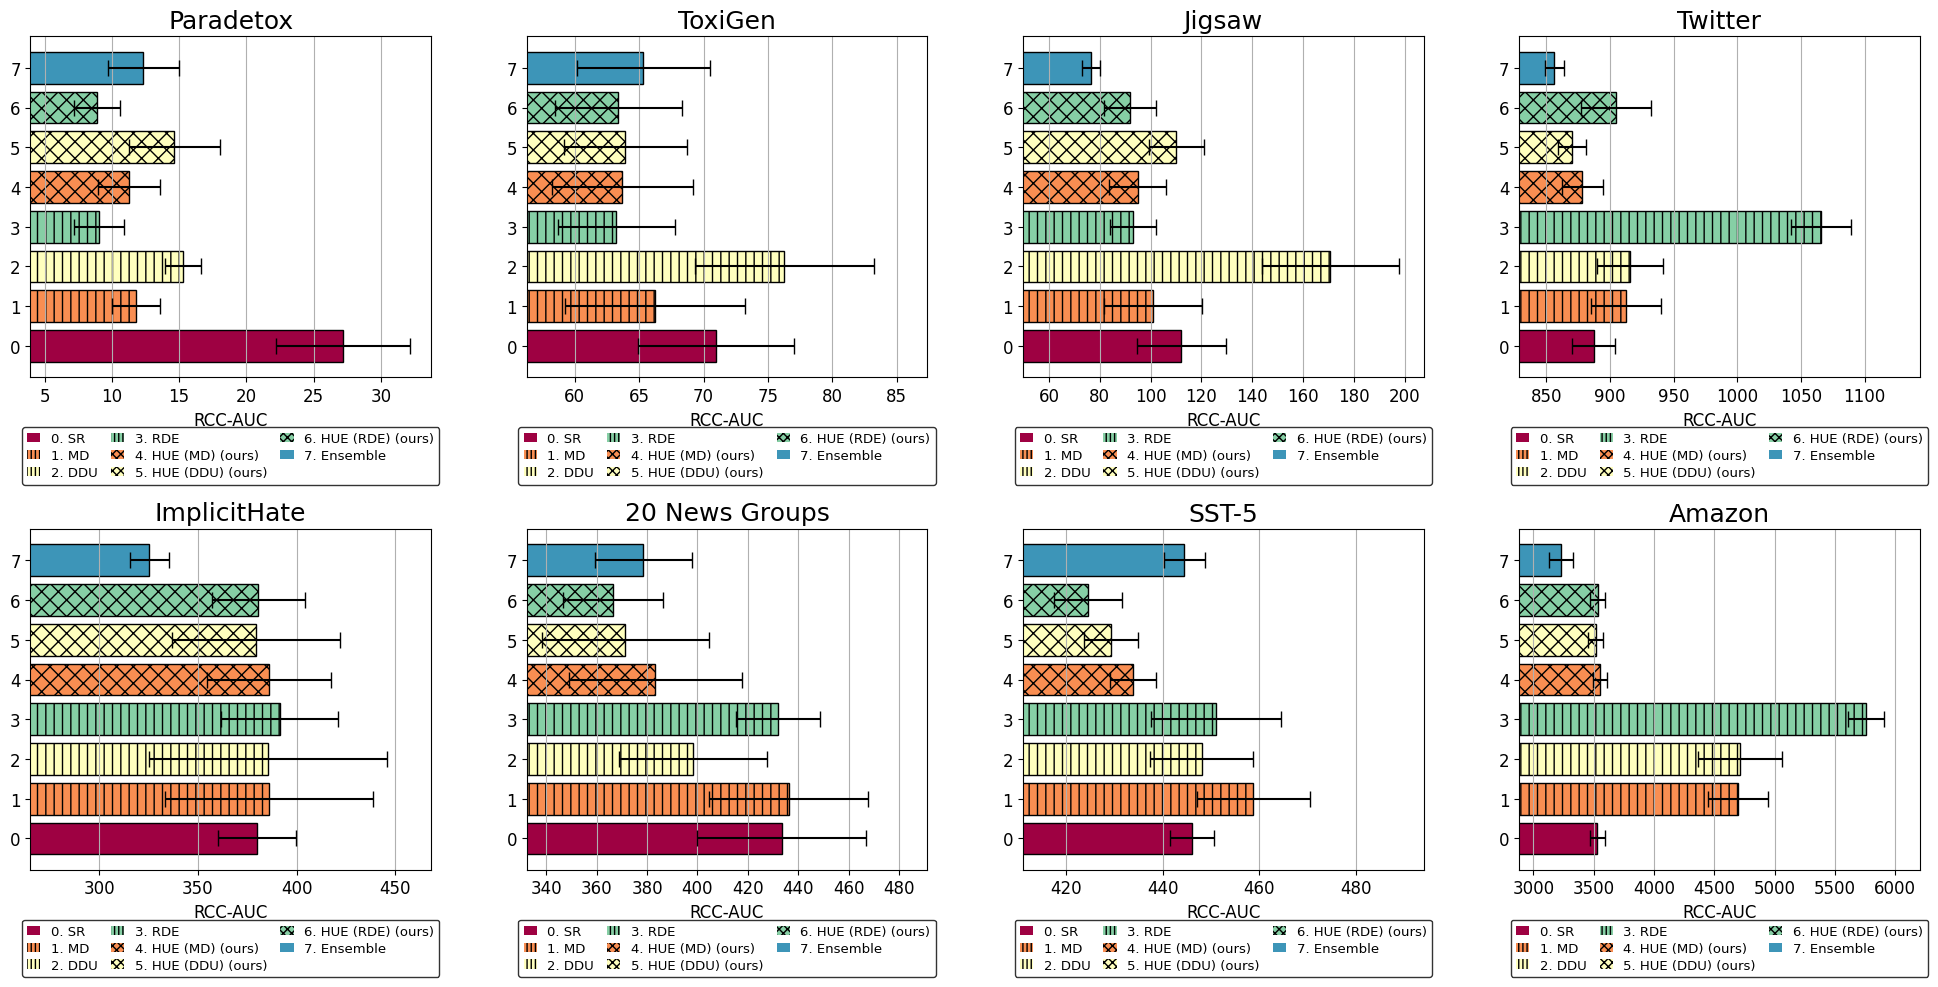

In [94]:
plot_bar_charts(electra_full, dataset_names, ['rcc-auc'])

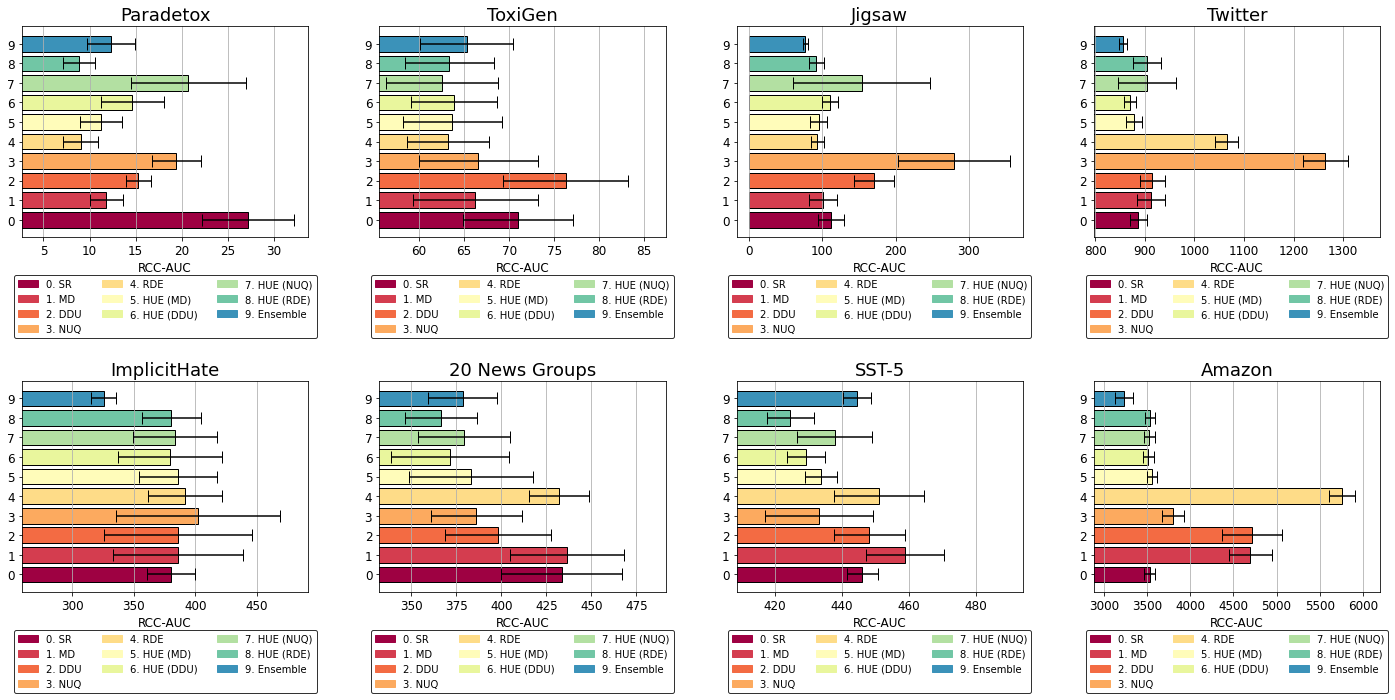

In [82]:
plot_bar_charts(electra_full, dataset_names, ['rcc-auc'])

In [95]:
bert_full = pd.concat([table_tox_comb.iloc[1::2].iloc[-1:], table_tox_comb.iloc[1::2].iloc[:-1]])
bert_full.style.apply(bold_best_pd, axis=None)

/tmp/ipykernel_1214497/2885636522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_col[col] = ''


,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
13,BERT,SR,-,21.83±5.02,76.36±3.84,72.88±11.20,896.71±10.93,441.35±39.75,342.56±25.88,495.25±21.38,4050.21±42.37
1,BERT,MD,-,10.39±0.97,74.49±4.66,93.96±14.54,932.50±26.00,426.26±47.47,322.68±12.01,460.70±9.66,5097.01±335.93
3,BERT,DDU,-,13.02±2.81,76.31±9.07,223.77±73.40,925.60±30.92,446.28±78.86,305.67±13.42,462.29±9.04,4819.17±251.74
5,BERT,RDE,-,8.55±1.83,72.68±3.47,74.01±10.06,1033.53±23.57,445.15±22.66,331.14±12.94,470.37±10.42,6299.17±443.67
7,BERT,HUE,MD,9.71±1.37,74.33±2.64,70.53±9.17,896.30±22.73,416.24±18.19,302.39±23.64,464.64±11.09,4051.15±68.20
9,BERT,HUE,DDU,11.77±2.18,73.72±2.94,74.47±8.47,903.38±37.43,426.43±39.46,294.45±18.78,467.16±12.97,4033.59±36.82
11,BERT,HUE,RDE,8.55±1.83,72.60±2.87,68.68±6.03,885.65±15.82,424.28±22.04,289.65±9.81,476.81±18.02,4046.09±46.42


In [96]:
bert_full = pd.concat([bert_full, table_ens.iloc[5:6]])[bert_full.columns].reset_index(drop=True)
#bert_full = bert_full.drop(columns=['DynaHate'])

In [97]:
bert_full.style.apply(bold_best_pd, axis=None)

/tmp/ipykernel_1214497/2885636522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_col[col] = ''


,Model,Method,Epistemic,Paradetox,ToxiGen,Jigsaw,Twitter,ImplicitHate,20 News Groups,SST-5,Amazon
,,,,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc,rcc-auc
0,BERT,SR,-,21.83±5.02,76.36±3.84,72.88±11.20,896.71±10.93,441.35±39.75,342.56±25.88,495.25±21.38,4050.21±42.37
1,BERT,MD,-,10.39±0.97,74.49±4.66,93.96±14.54,932.50±26.00,426.26±47.47,322.68±12.01,460.70±9.66,5097.01±335.93
2,BERT,DDU,-,13.02±2.81,76.31±9.07,223.77±73.40,925.60±30.92,446.28±78.86,305.67±13.42,462.29±9.04,4819.17±251.74
3,BERT,RDE,-,8.55±1.83,72.68±3.47,74.01±10.06,1033.53±23.57,445.15±22.66,331.14±12.94,470.37±10.42,6299.17±443.67
4,BERT,HUE,MD,9.71±1.37,74.33±2.64,70.53±9.17,896.30±22.73,416.24±18.19,302.39±23.64,464.64±11.09,4051.15±68.20
5,BERT,HUE,DDU,11.77±2.18,73.72±2.94,74.47±8.47,903.38±37.43,426.43±39.46,294.45±18.78,467.16±12.97,4033.59±36.82
6,BERT,HUE,RDE,8.55±1.83,72.60±2.87,68.68±6.03,885.65±15.82,424.28±22.04,289.65±9.81,476.81±18.02,4046.09±46.42
7,BERT,DE|SMP,-,9.78±1.81,70.45±1.07,47.42±1.22,861.36±6.45,337.29±10.82,291.63±11.39,480.44±7.93,3870.07±87.14


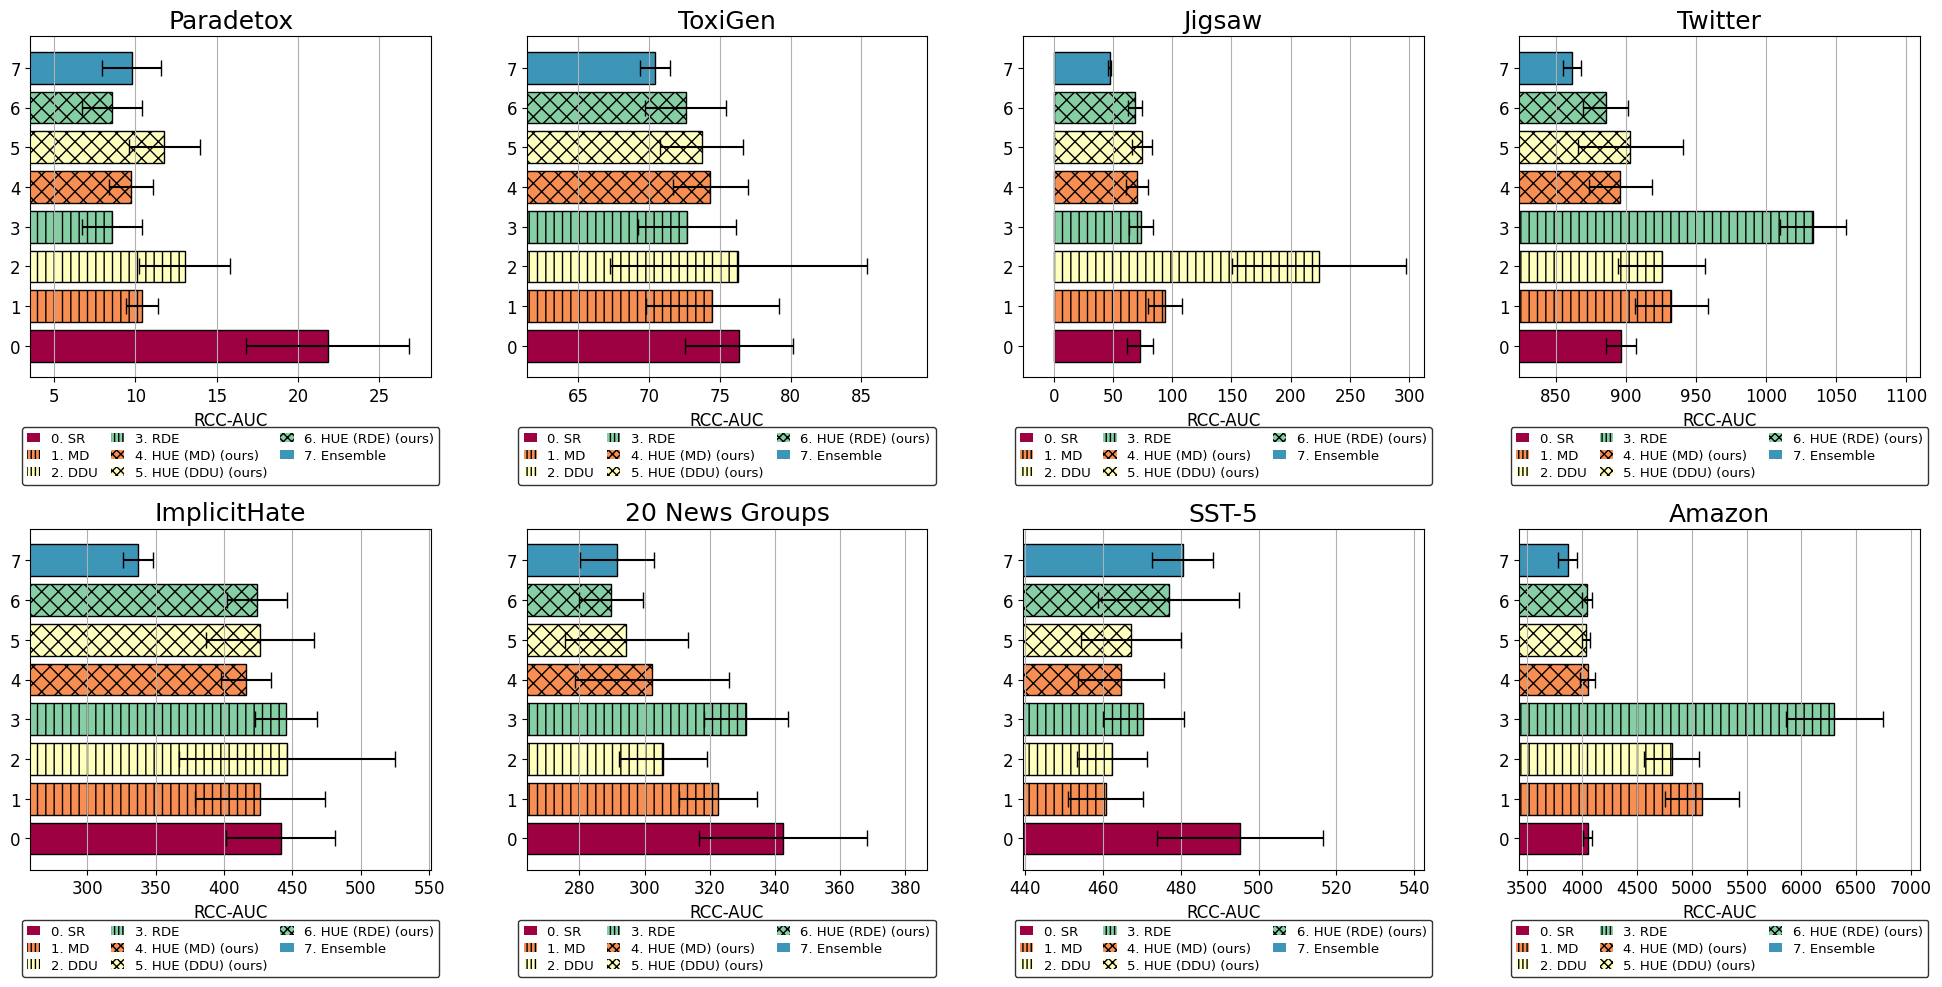

In [98]:
plot_bar_charts(bert_full, dataset_names, ['rcc-auc'], model_name='bert')

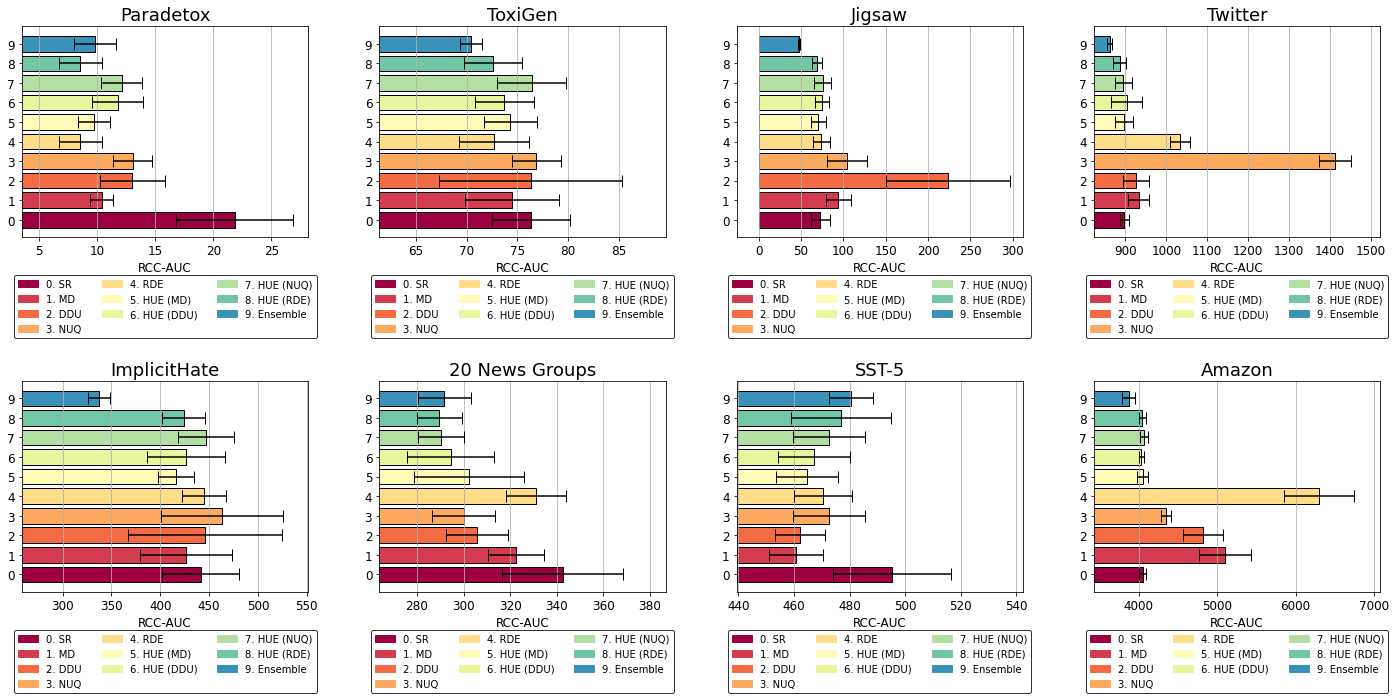

In [86]:
plot_bar_charts(bert_full, dataset_names, ['rcc-auc'], model_name='bert')

In [239]:
bert_md = table_tox_comb.iloc[2::3].iloc[::4].iloc[[2,0,1]]
print(prepare_latex(bert_md))
#bert_md.style.apply(bold_best_pd, axis=None)

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l|l|c|c|c|c|c|c|c|c}
\toprule
Method & Epistemic &          Paradetox &             ToxiGen &              Jigsaw &               Twitter &          ImplicitHate &              DynaHate &        20 News Groups &                SST-5 \\
       &            rcc-auc &             rcc-auc &             rcc-auc &               rcc-auc &               rcc-auc &               rcc-auc &               rcc-auc &              rcc-auc \\
\midrule
    SR &         - &         21.83$\pm$5.02 &          76.36$\pm$3.84 &         72.88$\pm$11.20 &          896.71$\pm$10.93 &          441.35$\pm$39.75 &          762.88$\pm$79.04 &          342.56$\pm$25.88 &         495.25$\pm$21.38 \\
    MD &         - &         10.39$\pm$0.97 &          74.49$\pm$4.66 &         93.96$\pm$14.54 &          932.50$\pm$26.00 &          426.26$\pm$47.47 & \textbf{667.44$\pm$36.00} &          322.68$\pm$12.01 & \textbf{460.70$\pm$9.66} \\
   HUE &        MD & \t

In [240]:
bert_ddu = table_tox_comb.iloc[2::3].iloc[[1,5,8]].iloc[[2,0,1]]
#bert_ddu.style.apply(bold_best_pd, axis=None)
print(prepare_latex(bert_ddu))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l|l|c|c|c|c|c|c|c|c}
\toprule
Method & Epistemic &           Paradetox &             ToxiGen &               Jigsaw &               Twitter &          ImplicitHate &              DynaHate &        20 News Groups &                SST-5 \\
       &             rcc-auc &             rcc-auc &              rcc-auc &               rcc-auc &               rcc-auc &               rcc-auc &               rcc-auc &              rcc-auc \\
\midrule
    SR &         - &          21.83$\pm$5.02 &          76.36$\pm$3.84 & \textbf{72.88$\pm$11.20} & \textbf{896.71$\pm$10.93} &          441.35$\pm$39.75 &          762.88$\pm$79.04 &          342.56$\pm$25.88 &         495.25$\pm$21.38 \\
   DDU &         - &          13.02$\pm$2.81 &          76.31$\pm$9.07 &         223.77$\pm$73.40 &          925.60$\pm$30.92 &          446.28$\pm$78.86 & \textbf{695.11$\pm$44.18} &          305.67$\pm$13.42 & \textbf{462.29$\pm$9.04} \\
   HUE &       

In [241]:
bert_rde = table_tox_comb.iloc[2::3].iloc[[3,7,8]].iloc[[2,0,1]]
#bert_rde.style.apply(bold_best_pd, axis=None)
print(prepare_latex(bert_rde))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l|l|c|c|c|c|c|c|c|c}
\toprule
Method & Epistemic &          Paradetox &             ToxiGen &              Jigsaw &               Twitter &          ImplicitHate &              DynaHate &       20 News Groups &                 SST-5 \\
       &            rcc-auc &             rcc-auc &             rcc-auc &               rcc-auc &               rcc-auc &               rcc-auc &              rcc-auc &               rcc-auc \\
\midrule
    SR &         - &         21.83$\pm$5.02 &          76.36$\pm$3.84 &         72.88$\pm$11.20 &          896.71$\pm$10.93 &          441.35$\pm$39.75 &          762.88$\pm$79.04 &         342.56$\pm$25.88 &          495.25$\pm$21.38 \\
   RDE &         - & \textbf{8.55$\pm$1.83} &          72.68$\pm$3.47 &         74.01$\pm$10.06 &         1033.53$\pm$23.57 &          445.15$\pm$22.66 & \textbf{651.42$\pm$44.32} &         331.14$\pm$12.94 & \textbf{470.37$\pm$10.42} \\
   HUE &       RDE &   